# Functional Programming in Python 

In [1]:
!pip install toolz

  Running setup.py bdist_wheel for toolz ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/3e/e9/72/b9e24c6b4c0347670b9a20afeba6b2534655f5dc714b30cb4e
Successfully built toolz
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import toolz
import operator
from operator import methodcaller, itemgetter, attrgetter

## Purity 

In [3]:
# pure
def add(a, b):
    return a + b

# impure
additions_made = 0
def add(a, b):
    global additions_made
    additions_made += 1
    return a + b

add(3, 5)
add(6, 8)
additions_made

2

## First class functions

In [4]:
def add(a, b):
    return a + b

add_function = add
    
add = lambda a,b: a + b

add(1,1)

2

## Higher order functions

In [5]:
from time import time, sleep

def timer(fn):
    def timed(*args, **kwargs):
        t = time()
        fn(*args, **kwargs)
        print("took {time}".format(time=time()-t))

    return timed

def compute():
    sleep(1)

timed_compute = timer(compute)
timed_compute()

took 1.0027246475219727


## Decorators

In [6]:
@timer
def compute():
    sleep(1)
    
compute()

took 1.0028371810913086


## Partial function application 

In [7]:
def add1(num):
    return add(1, num)
add1(1)

2

In [8]:
from functools import partial
add1 = partial(add, 1)
add1(1)

2

## Currying

In [9]:
def curried_add(a):
    def inner(b):
        return add(a,b)
    return inner

curried_add(1)
curried_add(1)(1)

2

## Function composition 

In [10]:
from toolz.curried import compose, map, filter, pipe, curry

compute = compose(map(lambda x: x**2), filter(lambda x: x%2==0))

list(compute(range(10)))

[0, 4, 16, 36, 64]

## Example: Simplified CSV parsing

In [11]:
csv = """firstName;lastName
Jim;Drake
Ben;James
Tim;Banes"""

In [12]:
lines = csv.split("\n")
matrix = [line.split(';') for line in lines]
header = matrix.pop(0)
records = []
for row in matrix:
    record = {}
    for index, key in enumerate(header):
        record[key] = row[index]
    records.append(record)
records

[{'firstName': 'Jim', 'lastName': 'Drake'},
 {'firstName': 'Ben', 'lastName': 'James'},
 {'firstName': 'Tim', 'lastName': 'Banes'}]

In [13]:
from toolz.curried import compose, map
from functools import partial
from operator import methodcaller

split = partial(methodcaller, 'split')
split_lines = split("\n")
split_fields = split(';')
dict_from_keys_vals = compose(dict, zip)
csv_to_matrix = compose(map(split_fields), split_lines)

matrix = csv_to_matrix(csv)
keys = next(matrix)
records = map(partial(dict_from_keys_vals, keys), matrix)
list(records)

[{'firstName': 'Jim', 'lastName': 'Drake'},
 {'firstName': 'Ben', 'lastName': 'James'},
 {'firstName': 'Tim', 'lastName': 'Banes'}]

In [14]:
from operator import methodcaller
methodcaller('split', ';')('foo;bar')

['foo', 'bar']

## fn.py

In [15]:
!pip install fn

  Running setup.py bdist_wheel for fn ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/ec/0b/f1/2e09d08831712bc4d4dd920ea1c966ebbca788264b0dda4dde
Successfully built fn
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
from fn import _

list(map(_**2, range(5)))

[0, 1, 4, 9, 16]

# PySpark

In [17]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [18]:
import random
NUM_SAMPLES = 1000000

def sample(p):
    x, y = random.random(), random.random()
    return 1 if x*x + y*y < 1 else 0

count = sc.parallelize(range(0, NUM_SAMPLES)).map(sample) \
             .reduce(lambda a, b: a + b)
print("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))

Pi is roughly 3.138912


## K-Means
mostly stolen and adapted from https://github.com/joelgrus/stupid-itertools-tricks-pydata/blob/master/src/k_means.py

In [38]:
import random
from toolz.curried import iterate, accumulate, curry, groupby, last, compose

In [39]:
def kmeans(k, points):
    return until_convergence(iterate(find_new_means(points), random.sample(points, k)))

In [40]:
@curry
def find_new_means(points, old_means):
    k = len(old_means)
    clusters = groupby(compose(str, closest_mean(old_means)), points).values()
    return list(map(cluster_mean, clusters))

In [41]:
@curry
def closest_mean(means, point):
    return min(means, key=squared_distance(point))

@curry
def squared_distance(p, q):
    return sum((p_i - q_i)**2 for p_i, q_i in zip(p, q))

In [42]:
def cluster_mean(points):
    num_points = len(points)
    dim = len(points[0]) if points else 0
    sum_points = [sum(point[j] for point in points)
                  for j in range(dim)]
    return [s / num_points for s in sum_points]

In [43]:
def no_repeat(prev, curr):
    if prev == curr: raise StopIteration
    else: return curr

def until_convergence(it):
    return last(accumulate(no_repeat, it))

In [44]:
data = [(random.random(), random.random()) for _ in range(500)]

In [45]:
k = 4
means = list(kmeans(k, data))
means

[[0.21952859841448114, 0.25481402534954994],
 [0.7652565865929, 0.7483653171083438],
 [0.264055940070528, 0.7509097028831765],
 [0.7225812094669304, 0.24038806923701367]]

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

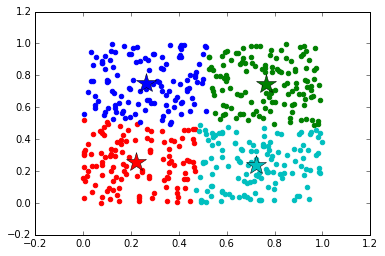

In [47]:
colors = iter(['r', 'g', 'b', 'c', 'm'])
clusters = groupby(compose(str, closest_mean(means)), data)
for mean in means:
    x, y = zip(*clusters[str(mean)])
    color = next(colors)
    plt.scatter(x, y, color=color)
    plt.plot(*mean, color=color, marker='*', markersize=20)